# Packages

In [1]:
import ee
import geemap

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Open Nighttime Lights'

# Invert an Image with Image functions

Previously, we executed some simple mathmatical operations on Images; however, sometimes we have multi-step operations or more complicated expressions we wish to apply.

For that, we can use the `.expression()` method built-in to the Image class.

Here, we’ll shift back to DMSP-OLS data and take a sneak peak at a process for intercalibrating DMSP data. Let's initialize the map with DMSP-OLS layer on Mexico City, pulling the annual DMSP-OLS nighttime lgihts composite for 1996, using the "stable lights" band.

In [2]:
# Center on Mexico City, Mexico
lat = 19.43
lon = -99.13
zoom = 6

map1 = geemap.Map(center = [lat, lon], zoom = zoom)
map1.add_basemap('SATELLITE')

# Get 1996 composite, apply mask and add as a layer
dmsp1996 = ee.Image('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996').select('stable_lights')
map1.addLayer(dmsp1996.mask(dmsp1996), {}, 'DMSP-OLS 1996', opacity = 0.75)
map1.addLayerControl()
map1

Map(center=[19.43, -99.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Let’s say we want to invert an image. We know our max value (our Digital Number, if you recall) for DMSP-OLS images is 63. So if we multiply everything by -1 and then add 63. So, for example what was a DN of 63 before (the max) is now a 0 and vice versa.

We can do this using the built-in functions `.multiply()` and `.add()`

Note: we selected our band, `stable_lights` above and saved to our variable `dmsp1996`, but if we didnt before we would have to do that here to explicitly apply our operation, including expression, to a specific band.

In [3]:
dmsp1996_inv = dmsp1996.multiply(-1).add(63)
dmsp1996_inv

We’ll view the transformed (inverted) image we just created and compare it to the original image with a split map.

Note: to ensure we’re comparing them on the same scale, we’re using the visual parameters in the `.addLayer()` function, which allows us to do a few things to our image, such as clip the image to “min” and “max” values.

In [5]:
map2 = geemap.Map(center = [lat, lon], zoom = zoom)
map2.addLayerControl()

dmsp96_tile = geemap.ee_tile_layer(dmsp1996, {'min': 0, 'max': 63}, 'DMSP NTL 1996', opacity = 0.75)
dmsp96inv_tile = geemap.ee_tile_layer(dmsp1996_inv, {'min': 0, 'max': 63}, 'DMSP NTL 1996 inverse', opacity = 0.75)

map2.split_map(left_layer = dmsp96_tile, right_layer = dmsp96inv_tile)
map2

Map(center=[19.43, -99.13], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

# Invert image with `.expression()`

Now, we’ll perform the same operation as we did before, but using the `expression()` method.

The `ee.Image.expression()` method takes a string input as the formula. The second argument is a dictionary with key-value pairs, where the keys are the characters in our string we want to use as variables, (e.g. “X”) and the values are the corresponding data – a particular Image band in this case.

In [6]:
inv_formula = '(X* - 1) + 63'

# Plug this formula in, identify our variable 'X' and set it to the "stable_lights" band
dmsp1996_inv2 = dmsp1996.expression(inv_formula, {'X': dmsp1996})
dmsp1996_inv2

In [7]:
# Visualize analyze to see that they are identical
map3 = geemap.Map(center = [lat, lon], zoom = zoom)
map3.addLayerControl()

dmsp96inv_tile = geemap.ee_tile_layer(dmsp1996_inv, {'min':0,'max':63}, 'DMSP 96 inverse', opacity=0.75)
dmsp96inv_tile2 = geemap.ee_tile_layer(dmsp1996_inv2, {'min':0,'max':63}, 'DMSP 96 inverse 2nd method', opacity=0.75)

map3.split_map(left_layer=dmsp96inv_tile, right_layer=dmsp96inv_tile2)
map3

Map(center=[19.43, -99.13], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

They’re equivalent!

So… why use the `expression()` method instead of the built-in functions?

This method used a couple very simple operations, but it can be necessary to use more complex formulae.

It can be easier to read an expression written in a form (like a string) that we’re familiar with. It may also be easier to dynamically update formulae with different variables when using the `.expression()` approach.

## Apply a polynomial function to calibrate a DMSP-OLS image

We cover DMSP-OLS intercalibration in more detail in a later exercise, but as an illustrative example of expressions, we’re going to look at this intercalibration formula, which applies a series of coefficients to an input DMSP-OLS image to get an “adjusted” image that corrects for sensor variation. These coefficients map to the formula:

$$ X' = C_0 + C_1 * X + C_2 * X^2 $$

Where:
- $X$: the input image, represented as a 2D matrix (recall these images are panchromatic so there is only one channel of light)
- $C_0, C_1, and C_2$: the calibration coefficients that are assigned to each satellite
- $X'$: the calibrated image

This is a table of the coefficients created using this method corresponding to specific DMSP-OLS satellite-year data:
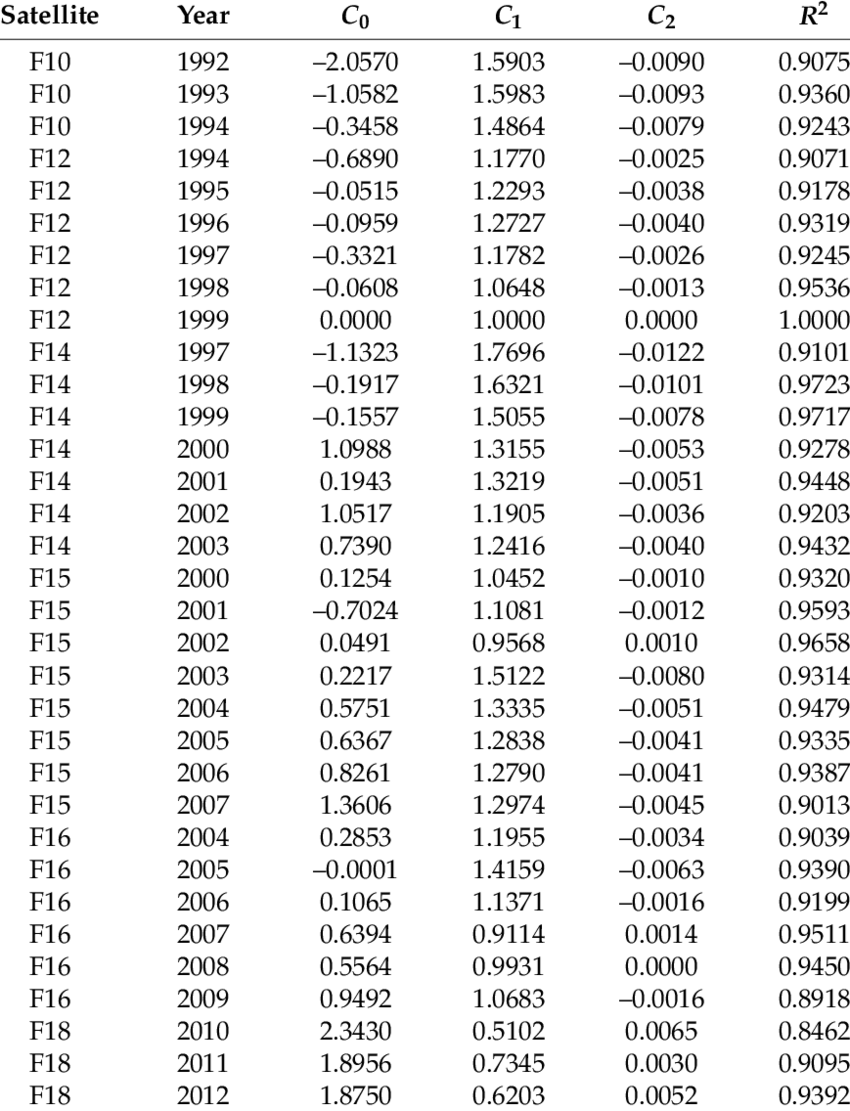

For 1996, there is only one satellite, F12, so we can reference the appropriate coefficients for F121996 from our table above:
- $C_0 = -0.0959$
- $C_1 = 1.2727$
- $C_2 = -0.0040$

We add our coefficients to the approprite terms of the polynomial, and set our image as the $X$ variable and save this formula as a string.

In [8]:
# Set formula
F121996cal = '-0.0959 + (1.2727 * X) + (-0.0040 * X * X)'

# Apply our expression to our 1996 composite
dmsp1996_clbr = dmsp1996.expression(F121996cal, {'X': dmsp1996})
dmsp1996_clbr

In [11]:
# Visualize
map4 = geemap.Map(center = [lat, lon], zoom = zoom)
map4.addLayerControl()

mask96 = geemap.ee_tile_layer(dmsp1996.mask(dmsp1996), {'min': 0, 'max': 63}, 'DMSP NTL 1996', opacity = 0.75)
adj96 = geemap.ee_tile_layer(dmsp1996_clbr.mask(dmsp1996_clbr), {'min': 0, 'max': 63}, 'DMSP NTL adjusted', opacity = 0.75)

map4.split_map(left_layer = mask96, right_layer = adj96)
map4

Map(center=[19.43, -99.13], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

Note that visually, the changes are hard to detect, but if you zoom in, you can see that the adjusted image has brighter values around the edges of the urban areas.

If we were actually conducting inter-calibration, we’d also clip the adjusted image to specific minimum and max values to account for the fact that some DN values are above our 63 max.